In [1]:
from src.data_transforms import *
from src.image_loader import ImageLoader
from src.esfpnet import ESFPNetStructure
from src.trainer_1 import *
import torch
import os
from torch.utils.data import DataLoader, random_split
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
torch.cuda.empty_cache()

%load_ext autoreload
%autoreload 2

c:\Users\shuvo\.conda\envs\ece_bmed_6780_project\lib\site-packages\mmcv\__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(


In [2]:
root_dir = os.getcwd()

In [3]:
runner = Trainer(model_name='esfpnet',
                 model_dir=os.path.join(root_dir, 'src'),
                 train_data_transforms=get_train_transforms(),
                 val_data_transforms=get_val_transforms(),
                 seg_type='infection',
                 train_im='./data/train/rp_im.nii.gz',
                 train_msk='./data/train/rp_lung_msk.nii.gz',
                 validation_im='./data/validation/medseg_im.nii.gz',
                 validation_msk=None,
                 batch_size=16,
                 load_from_disk=False)
runner.run_training_loop(num_epochs=30)
runner.plot_loss_history()
# runner.plot_accuracy()


SyntaxError: invalid syntax. Perhaps you forgot a comma? (1681595545.py, line 9)

In [ ]:
original_images = runner.original_images
prediction = runner.predictions
# runner.save_model('./Pretrained/lung_generator.pt')

In [ ]:
for i in range(len(prediction)):
    if i == 0:
        lung_mask = prediction[i]
        images = original_images[i]
    else:
        lung_mask = np.concatenate((lung_mask, prediction[i]))
        images = np.concatenate((images, original_images[i]))

lung_mask = np.swapaxes(lung_mask, 0, 2)
lung_mask = np.swapaxes(lung_mask, 0, 1)
lung_mask = lung_mask.astype('float')

images = np.squeeze(images, axis=1)
images = np.swapaxes(images, 0, 2)
images = np.swapaxes(images, 0, 1)

In [ ]:
# Save lung mask as a .gz file

nifti_lung_mask = nib.Nifti1Image(lung_mask, affine=np.eye(4))
# nib.save(nifti_lung_mask, './data/MedSeg/medseg_lung_msk.nii.gz')

In [ ]:
# Extract lung regions

lung_regions = np.zeros(lung_mask.shape)
for i in range(lung_mask.shape[2]):
    lung_index = lung_mask[:, :, i] != 0
    ignore_index = lung_mask[:, :, i] == 0
    lung_regions[:, :, i][lung_index] = images[:, :, i][lung_index]
    lung_regions[:, :, i][ignore_index] = np.min(images[:, :, i][ignore_index])

In [ ]:
# Save the extracted lung regions as a .gz file

nifti_lung_region = nib.Nifti1Image(lung_regions, affine=np.eye(4))
# nib.save(nifti_lung_region, './data/MedSeg/medseg_lung_im.nii.gz')

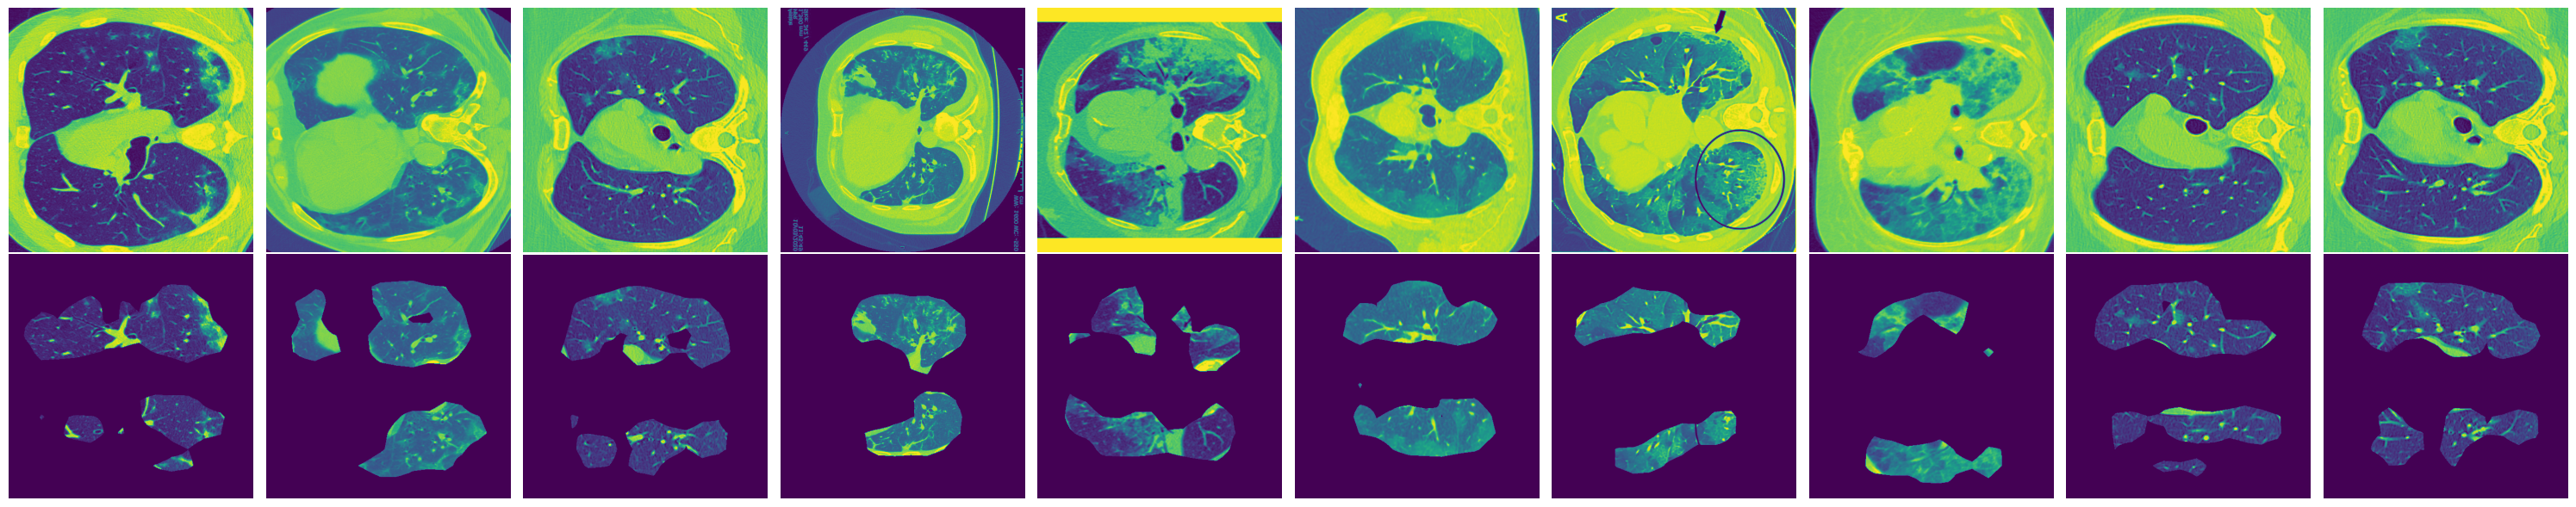

In [ ]:
# Show some extracted lung regions

plot_count = 1

fig = plt.figure(figsize=(30, 6))
for i in np.random.randint(100, size=10):
    plt.subplot(2, 10, plot_count)
    plt.imshow(images[:, :, i])
    plt.axis('off')
    
    plt.subplot(2, 10, plot_count+10)
    plt.imshow(lung_regions[:, :, i])
    plt.axis('off')
    plot_count += 1

plt.tight_layout()
plt.show()

In [ ]:
# fig.savefig('lung_segmentation_pspnet.pdf', format='pdf', dpi=1200)